# Подготовка

Извлечение содержимого исходного архива

In [1]:
import zipfile
import os

zip_file_name = "GID.zip"
temp_dir = "GID_DIR"
if not os.path.isdir(temp_dir):
    with zipfile.ZipFile(zip_file_name, "r") as zip_ref:
        zip_ref.extractall(temp_dir)

Импортим все важные для начальной обработки библиотеки

In [2]:
import numpy as np
import pandas as pd

import audio_parser as parser

Инициализируем список файлов в зависимости от пола и путь до wav файлов

In [3]:
wav_dir = f"{temp_dir}/wav_data/"
m_samples, f_samples = set(), set()
with open(f"{temp_dir}/m.txt", "r") as m_file, open(f"{temp_dir}/f.txt", "r") as f_file:
    m_samples = [line.strip() for line in m_file.readlines()]
    f_samples = [line.strip() for line in f_file.readlines()]
len(m_samples), len(f_samples)

(102, 102)

Как видно, аудиодорожки распределены поровну

Создаём пустой датафрейм

In [4]:
columns=[
    'nobs', 'mean', 'skew',
    'kurtosis', 'median', 'mode',
    'std', 'low', 'peak',
    'q25', 'q75', 'iqr',
    'gender'
]

wav_df = pd.DataFrame(columns=columns)

Заполним dataframe

In [5]:
for wav_name in os.listdir(wav_dir):        
    frequencies = parser.get_frequencies(os.path.join(wav_dir, wav_name))
    if frequencies:
        features = parser.get_features(frequencies)
        wav_name_dict = dict(zip(columns, features))
        wav_name_dict["gender"] = 0 if wav_name in f_samples else 1
        wav_df.loc[wav_name] = pd.Series(wav_name_dict)
wav_df["gender"] = wav_df["gender"].astype(int)

In [6]:
wav_df["gender"].value_counts()

1    102
0    102
Name: gender, dtype: int64

In [7]:
wav_df.head()

,nobs,mean,skew,kurtosis,median,mode,std,low,peak,q25,q75,iqr,gender
A30000L1.wav,29.0,391.923077,0.508911,0.102541,425.0,430.0,131.289649,185.0,760.0,290.00,470.00,180.00,0
A30002X6.wav,11.0,521.363636,0.762144,0.390925,490.0,255.0,158.960986,255.0,880.0,447.50,555.00,107.50,0
A30002D3.wav,6.0,470.000000,-0.885499,-0.428337,480.0,385.0,44.158804,385.0,515.0,456.25,503.75,47.50,0
A30003X5.wav,4.0,338.750000,-0.712180,-1.106827,352.5,275.0,39.902224,275.0,375.0,320.00,371.25,51.25,1
A30001X2.wav,17.0,303.065577,0.879618,1.781140,300.0,300.0,33.382551,240.0,390.0,300.00,300.00,0.00,1


# Графики

Импортируем библиотеки для рисования

In [8]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.rcParams["font.size"] = 18
plt.rcParams["figure.figsize"] = (20, 9)
sb.set_style("whitegrid", {'axes.grid' : False})

amplitude_str = "Amplitude (dB)"
frequency_str = "Frequency (Hz)"
time_str = "Time (s)"

## Аудиодорожка

Выберем произвольный звуковой файл и рассмотрим его

In [9]:
from scipy.io import wavfile

test_wav_file = f"{wav_dir}/A30000A3.wav"
rate, data = wavfile.read(test_wav_file)

зависимость Амплитуды от времени

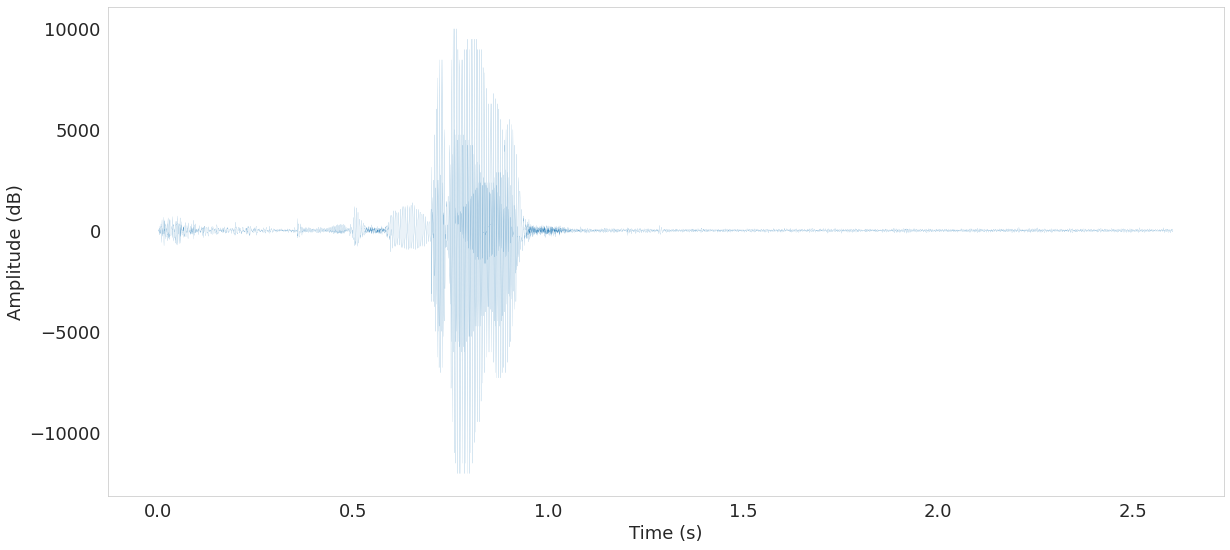

In [10]:
time = np.arange(0, float(data.shape[0]), 1) / rate
plt.plot(time, data, linewidth=0.1, alpha=0.9)
plt.xlabel(time_str)
_ = plt.ylabel(amplitude_str)

Зависимость амплитуды от частоты

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


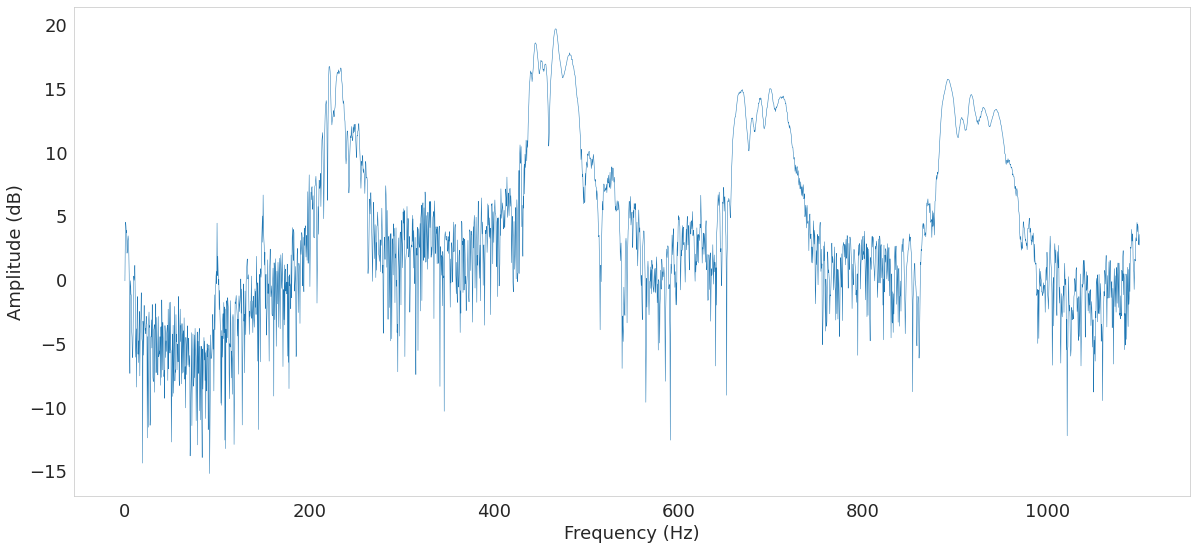

In [11]:
fourier = np.fft.fft(data)

n = len(data)
fourier = fourier[0:(n // 2)]
# scale by the number of points so that the magnitude does not depend on the length
fourier = fourier / float(n)
#calculate the frequency at each point in Hz
freqArray = np.arange(0, (n/2), 1.0) * (rate*1.0/n);
x = freqArray[freqArray <= 1100] # максимальная частота для человека
y = 10*np.log10(fourier)[0:len(x)]
plt.plot(x, y, linewidth=0.5)
plt.xlabel(frequency_str)
_ = plt.ylabel(amplitude_str)

Кажется, что без особых шумов и скачков

## Весь датасет

Построим график распределения для каждой из фич

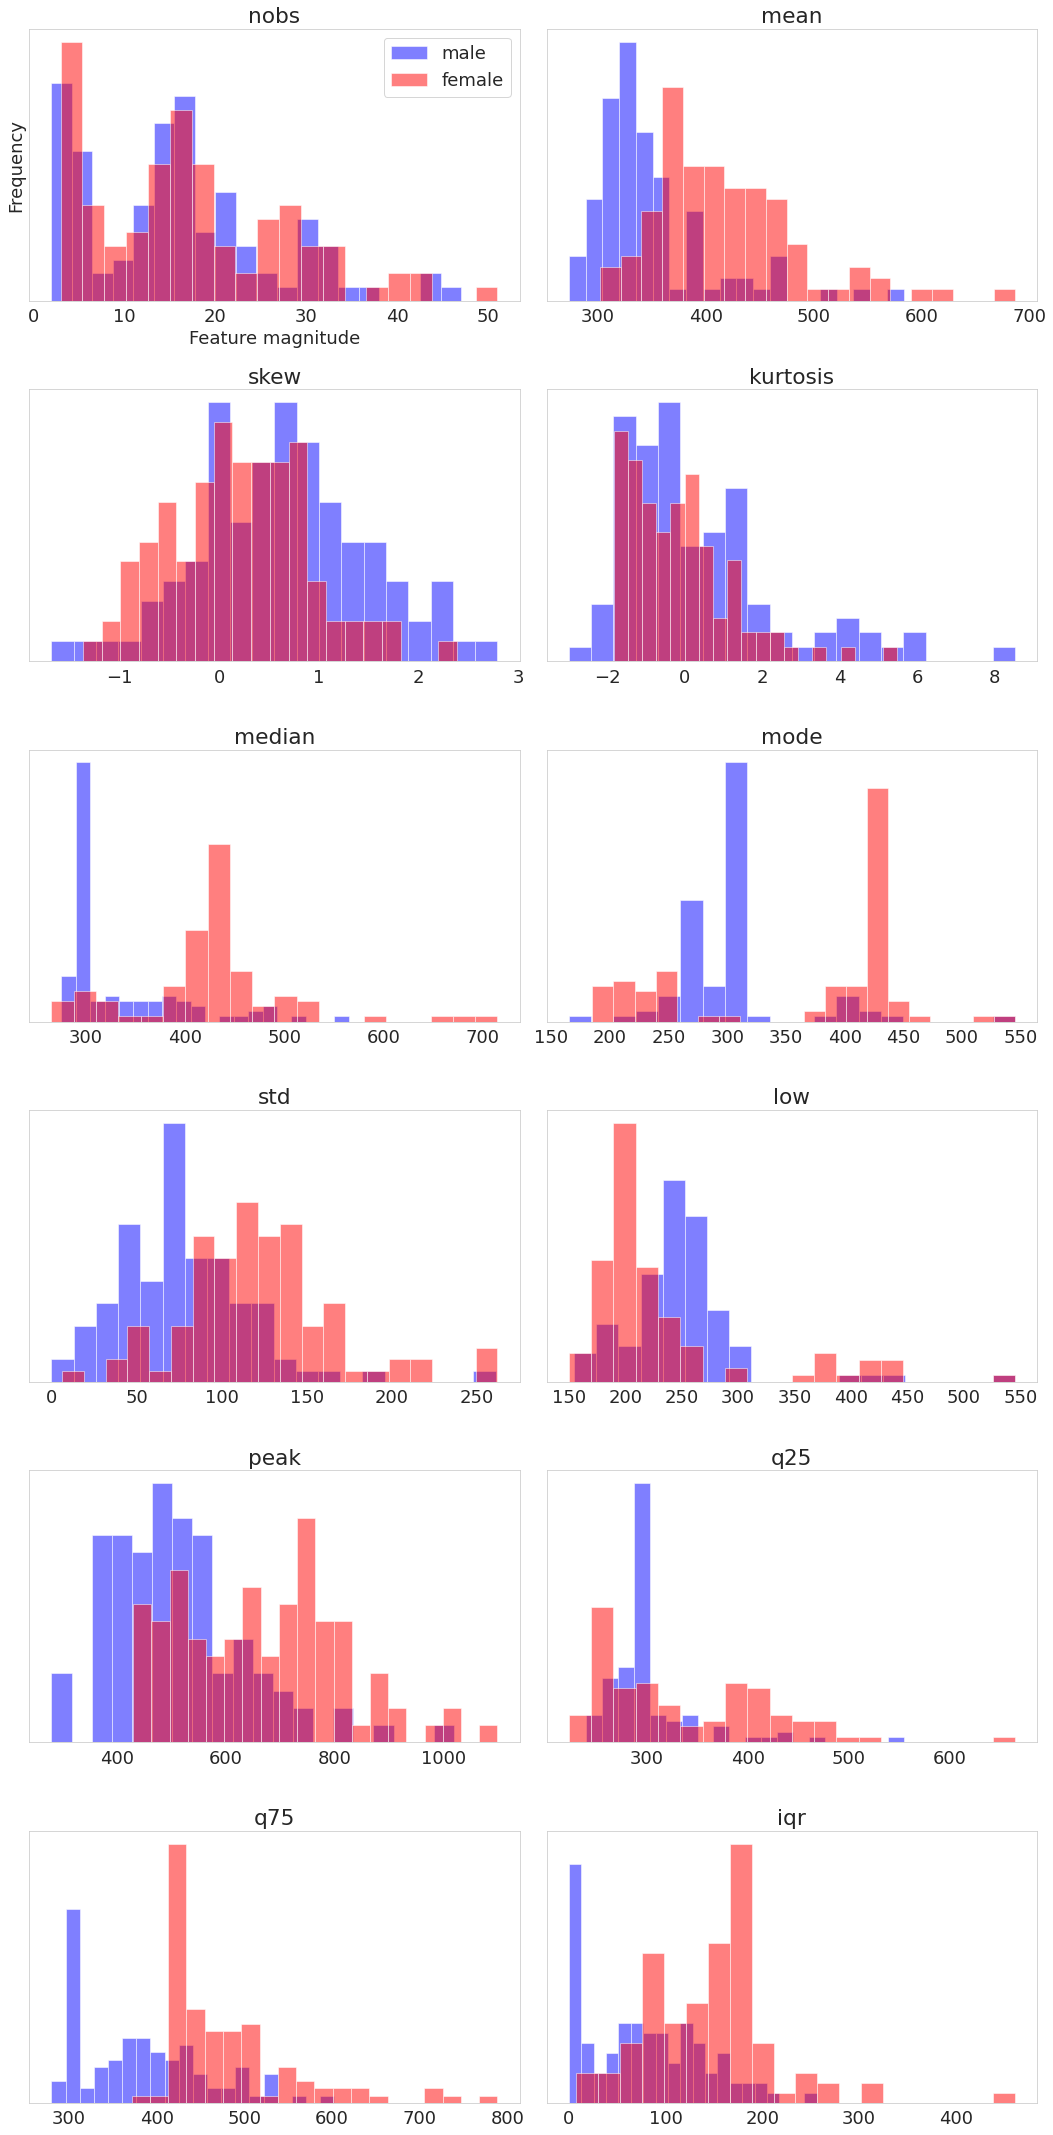

In [12]:
female = wav_df[wav_df.gender == 0]
male = wav_df[wav_df.gender == 1]

features_cols = [col for col in columns if col != "gender"]

# Будем рисовать гистограммы
fig, axes = plt.subplots(6, 2, figsize=(15,30))
ax = axes.ravel()
for i in range(len(features_cols)):
    ax[i].hist(male[features_cols[i]], bins=20, color='blue', alpha=.5)
    ax[i].hist(female[features_cols[i]], bins=20, color='red', alpha=.5)
    ax[i].set_title(features_cols[i])
    ax[i].set_yticks(())
    
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["male", "female"], loc="best")
_ = fig.tight_layout()

Как и следовало ожидать, мужчины, в основном, имеют частоту аудиодорожки ниже, чем у женщин.

У мужчин чаще встречаются частоты около 300 Гц, у женщин - около 425 Гц.

Разброс по частотам у женщин выше.

# Классификация

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set(font_scale = 2)
import pandas as pd
import xgboost as xgb
import lightgbm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [14]:
# Функция для проверки метрик входной модели по нашим данным X
def test_model(model):
    clf = model(random_state=69).fit(X_train, y_train)
    print(clf)
    print(f"training score: {clf.score(X_train, y_train):.3f}")
    print(f"test score: {clf.score(X_test, y_test):.3f}\n")

Протестируем несколько моделей в стоке, выберем лучшую

In [15]:
# Делим на train, test
y = wav_df["gender"]
X = wav_df.drop(columns=["gender"])

# Стандартизация (особенно важно для SVC)
scaler = StandardScaler()
X[:] = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=69)

models = [
    DecisionTreeClassifier, RandomForestClassifier, 
    GradientBoostingClassifier, SVC, 
    xgb.XGBClassifier, lightgbm.LGBMClassifier
]
for model in models:
    test_model(model)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=69, splitter='best')
training score: 1.000
test score: 0.824

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=69, verbose=0,
                       warm_st

Ансамблевые модели оказались, ожидаемо, впереди по тренировочным данным, но на практике же вверх взял SVM, что, впрочем, тоже не удивительно, поскольку наши данные выглядят вполне разделимыми даже "линейными" (у SVM есть классная фишка сводить всё к линейному разделению в признаковом пространстве большей размерности) моделями.

Выберем SVM (поскольку он даже быстрее ансамблевых моделей) и сделаем кросс-валидацию параметров для него.

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": np.arange(0.1, 5.0, 0.15),
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": range(2, 7),
    "gamma": [0.1, 0.25, 0.5, 0.75, 0.9, 1.5, 5, 50, 100],
}
clf = GridSearchCV(SVC(random_state=69), param_grid)
_ = clf.fit(X_train, y_train)

In [17]:
clf.best_estimator_, clf.best_score_

(SVC(C=2.65, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=2, gamma=0.1, kernel='rbf',
     max_iter=-1, probability=False, random_state=69, shrinking=True, tol=0.001,
     verbose=False), 0.9286021505376345)

Перейдём от сетки к модели

In [18]:
clf = clf.best_estimator_

Проверим основные метрики получившейся модели (средние по кросс-валидации)

In [29]:
from collections import namedtuple
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score


score_strats = ["accuracy", "f1"]
scores = namedtuple("Scores", score_strats)
score_means = [np.mean(cross_val_score(clf, X_test, y_test, cv=10, scoring=strat)) for strat in score_strats]
print(scores(*score_means))

Scores(accuracy=0.8200000000000001, f1=0.7433333333333334)


Сохраним модель и датафрейм со стандартизатором (для тестирования)

In [20]:
from joblib import dump

dump(clf, "best_model.joblib") 
# такое расширение, потому что так понятнее, какая либа использовалась 
dump(scaler, "scaler.joblib")
wav_df.to_csv("wav_df.csv")

Пробуем выполнить скрипт для тестирования

In [30]:
# вписываем в качестве входного аргумента к программе одно из двух:
# 1. путь до папки с *.wav файлами
# 2. путь до файла *.wav
!python "test_gender.py" GID_DIR/wav_data/A30001Q1.wav

A30001Q1.wav->male
